#Mission 3. Mission 2에서 학습시킨 모델로 건강관리를 위한 이미지 데이터 셋을 분류하시오.

##라이브러리 및 함수 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torch.backends import cudnn
cudnn.benchmark = True

import torchvision
from torchvision import models
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

from torchsummary import summary
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import os

from warnings import filterwarnings
filterwarnings('ignore')

import pickle

In [3]:
def save_pickle(data, route):
    '''
    data를 받아서 pickle 형식으로 저장
    '''
    with open(route, 'wb') as file:
        pickle.dump(data, file)
    print(f"{route} 저장 완료")

def load_pickle(route):
    '''
    저장된 pickle 파일을 불러오기
    '''
    with open(route, 'rb') as file:
        return pickle.load(file)

def save_model(model, optimizer, num_epochs, loss, accuracy_score):
    '''
    모델의 checkpoint를 '*.pt' 확장자 파일로 저장하는 함수
    '''
    # 모델을 저장할 경로를 지정하고 .pt 확장자를 사용
    now = datetime.now().strftime('%y%m%d%H%M%S')
    model_save_path = f'Mission3_{now}_{num_epochs}epochs_{round(accuracy_score, 2)}.pt'

    # 모델의 상태 및 다른 중요한 정보를 저장
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': num_epochs,  # 현재 에폭
        'loss': loss.item()  # 현재 손실
    }

    torch.save(checkpoint, model_save_path)

def load_model(model, optimizer, model_path):
    '''
    저장된 모델 checkpoint를 불러오는 함수
    '''
    checkpoint = torch.load(model_path)

    # 모델의 상태 및 중요한 정보를 불러옴
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return model, optimizer, epoch, loss

In [4]:
# 채점시 사용되는 코드
# 본인의 코드에 사용해도 된다.
@torch.no_grad()
def validate_epoch(model: nn.Module, testloader: torch.utils.data.dataloader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model in percent.
    '''
    model.eval()
    accuracies = []
    for images, labels in tqdm(testloader, total=len(testloader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.cat(accuracies).float().mean() * 100
    return accuracy.item()

# 클래스별 채점 코드
@torch.no_grad()
def validate_epoch_by_class(model: nn.Module, testloader: torch.utils.data.dataloader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model BY CLASSES in percent.
    '''
    # 초기 설정
    total_counts = {testloader.dataset.classes[i] : 0 for i in range(len(testloader.dataset.classes))}
    true_counts = {testloader.dataset.classes[i] : 0 for i in range(len(testloader.dataset.classes))}

    # 클래스별 채점 수행
    model.eval()
    for images, labels in tqdm(testloader, total=len(testloader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        results = pred == labels

        # tensor를 구성하는 각 원소의 라벨과 결과를 확인하여, 클래스별 정답 개수와 데이터 개수로 저장
        for i in range(len(results)):
            total_counts[testloader.dataset.classes[labels[i].item()]] += 1
            true_counts[testloader.dataset.classes[labels[i].item()]] += 1 if results[i].item() else 0

    # 데이터프레임으로 생성
    df = pd.merge(
        pd.DataFrame(total_counts, index=['total']).T.reset_index(),
        pd.DataFrame(true_counts, index=['true']).T.reset_index()
    )

    # accuracy 도출
    df['accuracy'] = df['true'] / df['total']

    return df.sort_values('accuracy', ascending=False).reset_index(drop=True)

In [5]:
import os
os.chdir('/content/drive/MyDrive/개별 폴더')

## 1. Mission2에서 학습시킨 모델을 활용해 건강관리를 위한 음식 이미지 데이터를 13개의 클래스로 분류하는 모델을 만들고 학습시킨다.

###데이터 전처리

In [6]:
# 정규화를 위한 mean, std 불러오기
load_route = '/content/drive/MyDrive/데이터 병합 관련/231031172524_normalize-params.pickle'
mean = load_pickle(load_route)['평균']
std = load_pickle(load_route)['표준편차']

# 데이터 변환 정의
transform = T.Compose([
    T.Resize((224, 224)),  # 이미지 크기 조정
    T.ToTensor(),  # 이미지를 텐서로 변환
    T.Normalize(mean=mean, std=std)  # 이미지 정규화
])

In [7]:
# 데이터셋 로딩
trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/데이터/train', transform=transform)
new_trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/데이터/kfood_health_train', transform=transform)
new_testset =  torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/데이터/kfood_health_val', transform=transform)

# 데이터로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
new_trainloader = torch.utils.data.DataLoader(new_trainset, batch_size=64, shuffle=True)
new_testloader = torch.utils.data.DataLoader(new_testset, batch_size=64, shuffle=False)

###모델 불러오기

In [8]:
# 저장된 모델을 불러올 경로 지정
model_load_path = '/content/drive/MyDrive/데이터 병합 관련/Mission2_231103033621_49epochs.pt'

# 모델의 가중치와 상태를 불러오기
model = models.resnet18(pretrained=False)
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
checkpoint = torch.load(model_load_path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Fine-Tuning할 모델 아키텍처 재정의 (ResNet-18)
num_classes = len(new_trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # 분류할 클래스 수에 맞게 수정

# CUDA 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

# 시드 설정
seed = 42
torch.manual_seed(seed)  # PyTorch 무작위 시드 설정
np.random.seed(seed)     # NumPy 무작위 시드 설정

# GPU 시드 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

cuda:0


모델 아키텍처를 맞춰주는 과정에서 시행착오가 있었다. 기존 모델은 42개의 클래스에 대한 학습을 진행했던 반면, 이번 모델에서는 13개 클래스에 대해 학습해야 하기 때문에 그 전환 과정을 수행해 주어야만 했다. 기존 모델을 불러올 때는 trainset을 통해 42개 클래스에 맞는 아키텍처로 로딩하고, 이후 13개 클래스에 맞도록 재정의하는 과정을 통해 이를 해결했다.

*해당 코드는 classifier의 개수가 다를 때 전이학습을 위해 팀이 해결한 방법을 보여주는 코드이다*

In [9]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

##파인튜닝 진행

파인튜닝은 다른 데이터셋으로 학습한 모델을 그와 유사한 데이터셋에 적용하고자 할 때 유용한 방법이다. 우리는 kfood 데이터를 통해 학습시킨 모델을 가지고 있는 만큼, 파인튜닝 과정을 거치면 **그와 유사한 kfood_health 데이터를 분류**하는 데에도 활용할 수 있으리라 기대하며 본 작업을 수행했다.

파인튜닝 시 데이터셋의 **크기와 유사성**에 따라 다음의 4가지 전략 중 하나를 채택할 수 있다.

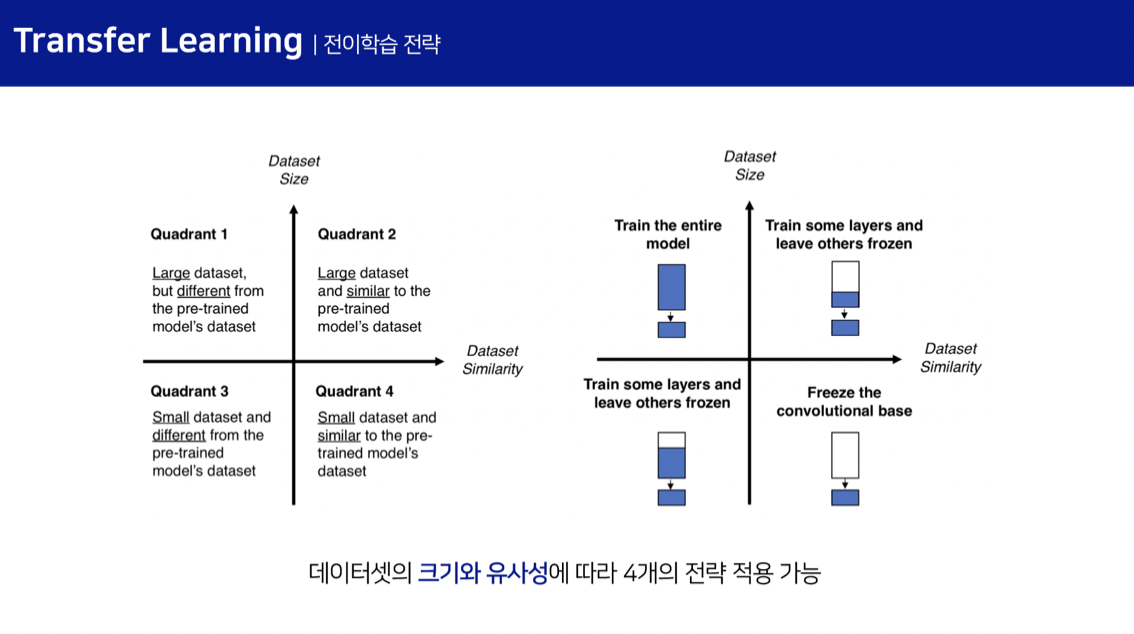

kfood와 kfood_health는 둘 다 음식 데이터인 만큼 유사성이 높은 것으로 간주할 수 있다. 따라서 다음의 두 전략을 동시에 수행하여 성능을 비교하기로 결정했다.

- 모델의 **classifier**만 학습
- 모델의 뒷부분을 구성하는 **일부 레이어(Layer4)와 classifier**를 학습

**따라서 아래의 실험에서는 위 두가지 방법론을 비교 분석해 더 나은 파인튜닝 방식을 채택하는 것을 목적으로 한다.**

###1-1.모델의 classifier 만 학습

데이터 간의 유사도가 높으면서 그 크기가 충분히 크지 않은 경우에는 fully-connected layer만 학습시키는 방법이 유용하다.

In [11]:
# 저장된 모델을 불러올 경로 지정
model_load_path = '/content/drive/MyDrive/데이터 병합 관련/Mission2_231103033621_49epochs.pt'

# 모델의 가중치와 상태를 불러오기
model = models.resnet18(pretrained=False)
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
checkpoint = torch.load(model_load_path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Fine-Tuning할 모델 아키텍처 재정의 (ResNet-18)
num_classes = len(new_trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # 분류할 클래스 수에 맞게 수정

# CUDA 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)
# 시드 설정
seed = 42
torch.manual_seed(seed)  # PyTorch 무작위 시드 설정
np.random.seed(seed)     # NumPy 무작위 시드 설정

# GPU 시드 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

cuda:0


In [12]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

**모델 불러오기**


In [13]:
# 손실 함수 정의
criterion = torch.nn.CrossEntropyLoss()

# 최적화 알고리즘 선택 (Layer4와 Layer5 파라미터만 업데이트)
lr = 0.0001
optimizer = optim.Adam(
    [
        {'params': model.layer4.parameters()},
        {'params': model.fc.parameters(), 'lr': lr}
    ],
    lr=lr
)

# learning Rate Scheduler
# 10 에폭마다 lr 감소하도록 함
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 모델의 모든 파라미터를 가져옴
params = model.named_parameters()

# fc 레이어의 파라미터를 제외하고 나머지 파라미터의 requires_grad를 False로 설정함
for name, param in params:
    if 'fc' not in name:
        param.requires_grad = False

**모델 학습하기**

* 해당 단계는 코드만 작성하고, 현 환경 아래에서 직접 실행은 진행하지 않으며 대신 미리 제작된 체크포인트 제출로 코드 실행을을 대신한다.

[Mission 3 fc 30 epochs. pt](https://drive.google.com/file/d/10micg8Iix3_kV_u6dgt2_-vDecWkRbDd/view?usp=sharing)

In [ ]:
# 훈련 반복
max_val_accuracy = 0
num_epochs = 30
new_scores = {}
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(tqdm(new_trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / (i + 1)
    accuracy = 100.0 * correct / total
    print(f'Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    #15이상 에포크마다 valduation 계산 (시간관계상)
    val_accuracy = 0
    if (epoch + 1) >= 15 or (epoch + 1) % 15 == 0:  # 15 에폭 이후부터는 모든 에폭에 검증을 수행하도록 설정
        val_accuracy = validate_epoch(model, new_testloader, device)
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

    # accuracy 저장
    new_scores[epoch] = [accuracy, val_accuracy]

    # 모델 저장
    save_model(model, optimizer, epoch, loss, val_accuracy)

    # 스케줄러 업데이트
    scheduler.step()

print('Training Finished')
now = datetime.now().strftime('%y%m%d%H%M%S')
save_route = f"{now}_파인튜닝_new_scores.pickle"
save_pickle(new_scores, save_route)

In [ ]:
validate_epoch(model, new_testloader, device)

*컴퓨팅 단위의 문제로 현 환경에서 불가피하게 수행을 완료하지 못했다. 다만 로컬에서 validation accuarcy를 확인한 결과는 다음과 같다*

* 30 epochs 수행시 정확도 80.95

###1-2.모델의 뒷부분(Layer4)과 classifier를 학습

파인튜닝 시에 데이터셋의 크기가 충분히 큰 경우 이 전략을 채택하는 것이 가장 좋다고 알려져 있다. 일반적으로 이미지의 개수가 1000개 이상인 경우에 데이터가 충분히 큰 것으로 간주한다. kfood_health 데이터는 이를 만족하기 때문에, 본 전략이 가장 좋은 파인튜닝 방법일 것으로 기대할 수 있다.

In [14]:
# 저장된 모델을 불러올 경로 지정
model_load_path = '/content/drive/MyDrive/데이터 병합 관련/Mission2_231103033621_49epochs.pt'

# 모델의 가중치와 상태를 불러오기
model = models.resnet18(pretrained=False)
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
checkpoint = torch.load(model_load_path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Fine-Tuning할 모델 아키텍처 재정의 (ResNet-18)
num_classes = len(new_trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # 분류할 클래스 수에 맞게 수정

# CUDA 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

# 시드 설정
seed = 42
torch.manual_seed(seed)  # PyTorch 무작위 시드 설정
np.random.seed(seed)     # NumPy 무작위 시드 설정

# GPU 시드 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

cuda:0


In [15]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [16]:
# 손실 함수 정의
criterion = torch.nn.CrossEntropyLoss()

# 최적화 알고리즘 선택 (Layer4와 Layer5 파라미터만 업데이트)
lr = 0.0001
optimizer = optim.Adam(
    [
        {'params': model.layer4.parameters()},
        {'params': model.fc.parameters(), 'lr': lr}
    ],
    lr=lr
)

# learning Rate Scheduler
# 10 에폭마다 lr 감소하도록 함
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 모델의 앞부분을 freeze하고 뒷부분만 학습
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.layer1.parameters():
    param.requires_grad = False
for param in model.layer2.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = False

optimizer에 학습할 레이어에 대한 파라미터만 넘겨줘야 하는 점을 잘 체크해야 했다. 기존처럼 model.parameters()를 모두 넘겨주는 것이 아닌, model.layer4.parameters()와 model.fc.parameters()를 명시해서 넘겨줬다

**모델 학습하기**

* 해당 단계는 코드만 작성하고, 현 환경 아래에서 직접 실행은 진행하지 않으며 대신 미리 제작된 체크포인트 제출로 코드 실행을을 대신한다.

[Mission3 30 epochs. pt](https://)

[Mission3 30.score pickle](https://drive.google.com/file/d/1GTCfHCCcuwLEdve_LG-p5IA9PmDgP5fV/view?usp=sharing)


In [ ]:
# 훈련 반복
max_val_accuracy = 0
num_epochs = 30
new_scores = {}
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(tqdm(new_trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / (i + 1)
    accuracy = 100.0 * correct / total
    print(f'Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # 매 epoch에서 validation accuracy 계산
    val_accuracy = validate_epoch(model, new_testloader, device)

    # accuracy 저장
    new_scores[epoch] = [accuracy, val_accuracy]

    # 모델 저장
    save_model(model, optimizer, epoch, loss, val_accuracy)

    # 스케줄러 업데이트
    scheduler.step()

print('Training Finished')

In [ ]:
now = datetime.now().strftime('%y%m%d%H%M%S')
save_route = f"{now}_파인튜닝_new_scores.pickle"
save_pickle(new_scores, save_route)

*컴퓨팅 단위의 문제로 현 환경에서 불가피하게 수행을 완료하지 못했다. 다만 로컬에서 validation accuarcy를 확인한 결과는 다음과 같다*

* 30 epochs 수행시 정확도 95.35

**결론: 따라서 성능이 우월한 두번째 방법 (layer4, classifier 동결) 방법을 채택한다.**

## 2. 성능 경향 파악 및 결과 분석

보다 더 최적화된 모델 정도를 파악하기 파악하기 위해 2번째 실험 모델의 성능을 시각화 하도록 한다.

###성능 시각화

In [19]:
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 10.8 MB/s eta 0:00:00


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import pickle

In [21]:
def save_scores(scores):
    '''
    epoch별 train accuracy와 validation accuracy를 pickle 파일로 저장
    '''
    with open('scores.pickle', 'wb') as file:
        pickle.dump(scores, file)

def load_scores(route):
    '''
    epoch별 train accuracy와 validation accuracy가 저장된 파일을 불러오기
    '''
    with open(route, 'rb') as file:
        return pickle.load(file)

In [22]:
load_path = '/content/drive/MyDrive/데이터 병합 관련/231103140007_파인튜닝_new_scores.pickle'
score_df = pd.DataFrame(load_scores(load_path), index=['test', 'val']).T.rename(columns={'test': 'train'})
score_df

,train,val
0,60.056677,78.798187
1,81.983705,84.070297
2,86.737513,87.301590
3,89.755579,89.909294
4,91.562168,90.816322
5,93.382926,92.120186
6,94.544810,93.424042
7,95.607510,93.707481
8,96.415161,94.501137
9,96.847326,94.841270


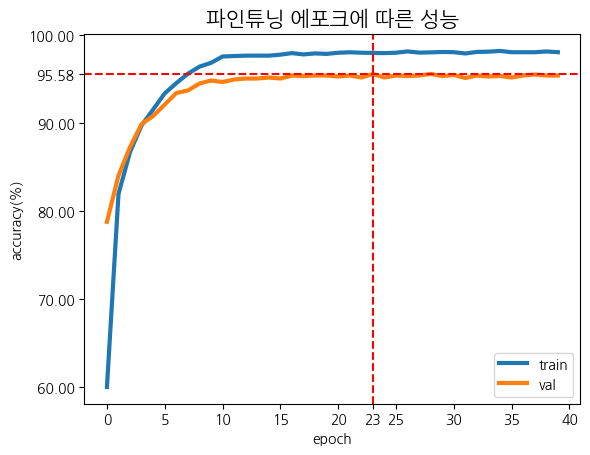

In [23]:
score_df.plot(kind='line', linewidth=3)
plt.title('파인튜닝 에포크에 따른 성능', size=15)
plt.xlabel('epoch')
plt.ylabel('accuracy(%)')
plt.axvline(23, linestyle='--', color='red')
plt.axhline(95.58, linestyle='--', color='red')
plt.xticks([i for i in range(0, 41, 5)] + [23])
plt.yticks([i for i in range(60, 101, 10)] + [95.58])
plt.legend(loc='lower right')
plt.show()

모델의 뒷부분(Layer4)과 classifier를 학습시켰을 때, 대략 15epoch 이후에서 수렴하는 양상을 보였다. 23epoch에서 validation accuracy 95.58로 가장 높은 성능을 기록했다.

제출의 편의를 위해 [Mission3_231103103256_23epochs_95.58.pt](https://drive.google.com/file/d/10fzmmAWsQWP0WZ_1L64HkZka4k-k5svy/view?usp=sharing) 의 이름을 Mission3.pt로 변경해 제출한다.